**Making Predictions With Pretrained DeepCell Models**<br>
NuclearSegmentation and CytoplasmSegmentation pretrained models were trained on 512x512 images. Mesmer were trained on 256x256 images. <br>
The NuclearSegmentation model is trained from a general_nuclear_train_large dataset, which comprises pooled nuclear data from HEK293, HeLa-S3, NIH-3T3, and RAW264.7 cells.<br>
The CytoplasmSegmentation model is trained from a general_cyto dataset, which comprises pooled phase and fluorescent cytoplasm data - computationally curated.<br>
Nuclear model works better than cyto model. <br>

In [1]:
import ssl 
ssl._create_default_https_context = ssl._create_unverified_context

from deepcell.applications import NuclearSegmentation
from deepcell.applications import CytoplasmSegmentation
from deepcell.applications import Mesmer

app = NuclearSegmentation()
appc = CytoplasmSegmentation()
appm = Mesmer()

2022-11-07 11:12:23.510102: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14657 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 7.0
2022-11-07 11:12:23.566248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14657 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-11-07 11:12:23.569073: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14657 MB memory:  -> device: 2, name: Tesla V100-PCIE-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0


A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 6a244f561b4d37169cb1a58b6029910f so we will re-download the data.
96903168/96894291 [==============================] - 43s 0us/step


In [3]:
print([(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), app.model.layers)])
print([(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), appc.model.layers)])
print([(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), appm.model.layers)])
# vars(app)

[('semantic_0', (None, 512, 512, 1)), ('semantic_1', (None, 512, 512, 1))]
[('semantic_0', (None, 512, 512, 1)), ('semantic_1', (None, 512, 512, 1))]
[('semantic_0', (None, 256, 256, 1)), ('semantic_1', (None, 256, 256, 3)), ('semantic_2', (None, 256, 256, 1)), ('semantic_3', (None, 256, 256, 3))]


In [4]:
import numpy as np
from skimage import io
%matplotlib inline
from matplotlib import pyplot as plt
import syotil
import tensorflow as tf #tf.stack

In [71]:
import os
print(os.getcwd())
INPUT_PATH="images/test/"
FILENAMES = [f for f in os.listdir("images/training/testimages")]
print(FILENAMES)

# DAPI files
DAPI_files = os.listdir("images/DAPI")
DAPI_file_name = [f.split("_DAPI")[0] for f in DAPI_files]
print(DAPI_file_name)

/home/yfong/deeplearning/dense_cell_segmentation
['M926910_CFL_Position7_CD3_test_img.png', 'M872956_JML_Position10_CD3_test_img.png', 'M872956_JML_Position8_CD8_test_img.png', 'M926910_CFL_Position13_CD3_test_img.png', 'M872956_JML_Position8_CD3_test_img.png', 'M872956_JML_Position8_CD4_test_img.png', 'M872956_JML_Position9_CD3_test_img.png']
['JML_Position8', 'CFL_Position13', 'JML_Position9', 'CFL_Position7', 'JML_Position10']


In [54]:
import tensorflow as tf
#new
DAPI=io.imread("images/DAPI/"+DAPI_files[DAPI_file_name.index(CURR_IM_NAME.split("_")[1]+"_"+CURR_IM_NAME.split("_")[2])])
DAPI=np.expand_dims(np.expand_dims(DAPI[:,:(int(DAPI.shape[1]/6)+1),2], axis=0), axis=-1)
print(DAPI.shape)
print(x.shape)
xnew=tf.concat([DAPI, x], axis=-1)
print(xnew.shape)

(1, 1040, 233, 1)
(1, 1040, 233, 1)
(1, 1040, 233, 2)


In [55]:
AP_mat=[]
for CURR_IM_NAME in FILENAMES:
    im0 = io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME))
    mask_true=io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME.replace("img","masks")))
    DAPI=io.imread("images/DAPI/"+DAPI_files[DAPI_file_name.index(CURR_IM_NAME.split("_")[1]+"_"+CURR_IM_NAME.split("_")[2])])

    APs=[]

    # for nuclear and cyto
    x = np.expand_dims(im0, axis=-1)
    x = np.expand_dims(x, axis=0)
    y, tile_info = app._tile_input(x)
    
    for mpp_select in [1,1.3]:
        pred = app.predict(y, image_mpp=mpp_select)
        prd = app._untile_output(pred, tile_info)
        APs.append(syotil.csi(mask_true, prd[0,:,:,0])) 

        pred = appc.predict(y, image_mpp=mpp_select)
        prd = appc._untile_output(pred, tile_info)
        APs.append(syotil.csi(mask_true, prd[0,:,:,0])) 
        
    # for mesmer
    DAPI=np.expand_dims(np.expand_dims(DAPI[:,:(int(DAPI.shape[1]/6)+1),2], axis=0), axis=-1)
    xnew=tf.concat([DAPI, x], axis=-1)
    y, tile_info = app._tile_input(xnew)
    
    for mpp_select in [1,1.3]:
        pred = appm.predict(y, image_mpp=mpp_select)
        prd = appm._untile_output(pred, tile_info)
        APs.append(syotil.csi(mask_true, prd[0,:,:,0])) 
    
    AP_mat.append(APs)
    
# APs["mAP"]=np.mean(list(APs.values()))
print(AP_mat)

[[0.11313131313131314, 0.010657193605683837, 0.146484375, 0.020833333333333332, 0.10871694417238002, 0.09065679925994449], [0.16993464052287582, 0.013779527559055118, 0.1446280991735537, 0.028735632183908046, 0.09886714727085479, 0.07339449541284404], [0.3125, 0.07913669064748201, 0.22459893048128343, 0.2037037037037037, 0.06745362563237774, 0.043689320388349516], [0.17229729729729729, 0.01935483870967742, 0.2018348623853211, 0.041916167664670656, 0.1111111111111111, 0.1127946127946128], [0.373046875, 0.05343511450381679, 0.40219378427787933, 0.09724770642201835, 0.18475750577367206, 0.155005382131324], [0.48633879781420764, 0.059190031152647975, 0.3978260869565217, 0.178125, 0.12928759894459102, 0.11772151898734177], [0.29683698296836986, 0.061124694376528114, 0.29698375870069604, 0.10952380952380952, 0.12929848693259974, 0.10682110682110682]]


In [77]:
import pandas as pd
# df = pd.DataFrame([FILENAMES, [x[0] for x in AP_mat], [x[1] for x in AP_mat]])
df = pd.DataFrame(AP_mat).transpose()
df['mean'] = df.mean(axis=1)
print(df)
df=df.iloc[[0,2,4]] # save only results from mpp=1
print(df)
df.columns=FILENAMES+["mAP"]
model_name="dc_model_zoo"
df.to_csv('APresults/csi_'+model_name+'.txt', index=False, header=False)

          0         1         2         3         4         5         6  \
0  0.113131  0.169935  0.312500  0.172297  0.373047  0.486339  0.296837   
1  0.010657  0.013780  0.079137  0.019355  0.053435  0.059190  0.061125   
2  0.146484  0.144628  0.224599  0.201835  0.402194  0.397826  0.296984   
3  0.020833  0.028736  0.203704  0.041916  0.097248  0.178125  0.109524   
4  0.108717  0.098867  0.067454  0.111111  0.184758  0.129288  0.129298   
5  0.090657  0.073394  0.043689  0.112795  0.155005  0.117722  0.106821   

       mean  
0  0.274869  
1  0.042383  
2  0.259221  
3  0.097155  
4  0.118499  
5  0.100012  
          0         1         2         3         4         5         6  \
0  0.113131  0.169935  0.312500  0.172297  0.373047  0.486339  0.296837   
2  0.146484  0.144628  0.224599  0.201835  0.402194  0.397826  0.296984   
4  0.108717  0.098867  0.067454  0.111111  0.184758  0.129288  0.129298   

       mean  
0  0.274869  
2  0.259221  
4  0.118499  


**Additional Testing**

(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}


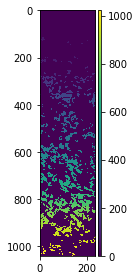

0.1402359108781127

In [16]:
x=im
y, tile_info = app._tile_input(x)
print(x.shape)
print(y.shape)
print(tile_info)
pred = app.predict(y, image_mpp=2) 
prd = app._untile_output(pred, tile_info)
io.imshow(prd[0,:,:,0])
plt.show()
syotil.csi(mask_true, prd[0,:,:,0])
# no image_mpp => 0.2
# image_mpp=1 => 0.37
# image_mpp=2 => 0.14

(256, 256, 3)


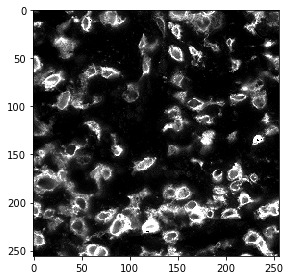

In [9]:
# second example, comparing NuclearSegmentation with CytoplasmSegmentation
im0 = io.imread('images/square_patches/M872956_JML_Position8_CD3_img_patch256x256.png')
print(im0.shape)
im=im0[:,:,2]
io.imshow(im)
plt.show()
im = np.expand_dims(im, axis=-1)
im = np.expand_dims(im, axis=0)

(256, 256)


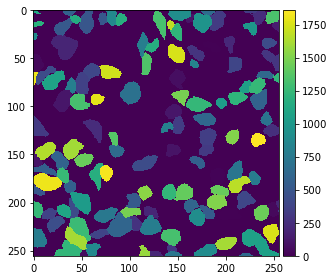

In [10]:
mask_true=io.imread("images/square_patches/M872956_JML_Position8_CD3_masks_patch256x256.png")
print(mask_true.shape)
io.imshow(mask_true)
plt.show()

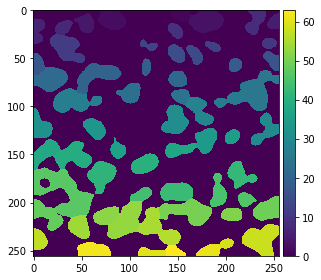

0.20833333333333334

In [11]:
y = app.predict(im)#, image_mpp=1) # set image_mpp to 1 improve to 0.35
io.imshow(y[0,:,:,0])
plt.show()
syotil.csi(mask_true, y[0,:,:,0])

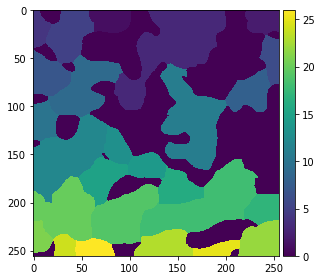

0.006060606060606061

In [12]:
yc = appc.predict(im)#, image_mpp=1) # set image_mpp to 1 improves to 0.01
io.imshow(yc[0,:,:,0])
plt.show()
syotil.csi(mask_true, yc[0,:,:,0])